# Detailed Chemistry Modeling in WaterTAP: Tutorial for Chemical Precipitation
*A step-by-step guide for integrating Reaktoro-PSE and WaterTAP models to predict precipitation performance*


---

## 1. Introduction

Chemical precipitation is a core mechanism in water treatment, hydrometallurgy, brine treatment, and critical mineral recovery. It describes the process in which dissolved ions combine to form a solid mineral phase once their activities exceed the solubility limit of that mineral.

Learning objectives:

- Modeling precipitation of various minerals 
- Adding reagents to control pH and alkalinity
- Setting up and solving a PrOMMiS flowsheet model with integrated Reaktoro chemistry databases and calculations




---

## 2. What Is Chemical Precipitation?

Chemical precipitation occurs when the **ionic activity product (IAP)** of certain ions exceeds a mineral’s **solubility product (Ksp)**:

$$
\text{IAP} = \prod_i a_i^{\nu_i},\qquad
\text{If IAP} > K_\text{sp},\ \text{mineral formation occurs.}
$$

Typical mineral categories for critical mineral and brine systems include:

- **Carbonates** (e.g., calcite, dolomite, siderite)  
- **Sulfates** (e.g., gypsum, barite)  
- **Hydroxides** (e.g., Mg(OH)₂, Fe(OH)₃)  
- **Mixed solid solutions** (e.g., transition-metal hydroxides or carbonates)

Reaktoro allows defining any number of aqueous species and solids from selected thermodynamic databases (e.g., PHREEQC, SUPCRT, EQ3/6). PrOMMiS has the capability to develop a predictive model for the precipitation process. The integration of both capabilities inside the PrOMMiS hub would enhance the existing PrOMMiS model to consider detailed water chemistry.



---

## 3. Precipitation Processes Example Case
In this example, the goal is to precipitate calcium carbonate by adding lime ($\text{CaO}$) to raise the $\text{pH}$ above 7 and reduce the solubility of calcite, while adding soda ash will provide the carbonate (CO3) ions to facilitate calcite formation. Finally, the calcite ($\text{CaCO}_3$) precipitates in the sludge.

<img src="precipitation_pfd.png" alt="Chemical Precipitation PFD" width="80%">



The inlet water composition is given below (concentrations in $\text{mg/L}$ as the ion):

| Ion | Concentration ($\text{mg/L}$) |
| :--- | :--- |
| $\text{Na}^+$ | 10556 |
| $\text{K}^+$ | 380 |
| $\text{Ca}^{2+}$ | 400 |
| $\text{Mg}^{2+}$ | 1272 |
| $\text{Cl}^-$ | 18980 |
| $\text{SO}_4^{2-}$ | 2649 |
| $\text{HCO}_3^-$ | 140 |


Reagents **Sodium Carbonate** ($\text{Na}_2\text{CO}_3$) and **Calcium Oxide (Lime)** ($\text{CaO}$) as $\text{pH}$ adjusters, with doses of **1e-5 $\text{mol/L}$** and **1e-5 $\text{mol/L}$**, respectively.



# 4. Model Development for Precipitation Processes with Detailed Chemistry

This section details the development of the precipitation model. Our strategy involves a modular approach:

1.  **Develop the Process Flowsheet Model:** Define the unit operations using **PrOMMiS** components.
2.  **Develop the Detailed Chemistry Model:** Use **Reaktoro-PSE** to accurately calculate chemical equilibrium, speciation, and mineral precipitation (using the Pitzer database) for the high-salinity feed stream.
3.  **Integrate:** Transfer the calculated chemistry parameters from Reaktoro into the PrOMMiS property model to achieve high-fidelity process simulation.

---

### 4.1. Import Modules from the Library
Import the core packages from [Pyomo](https://pyomo.readthedocs.io/en/stable/index.html), [IDAES](https://idaes-pse.readthedocs.io/en/stable/), and [Reaktoro PSE](https://github.com/watertap-org/reaktoro-pse) that will be needed for the integration of detailed chemistry predictions. 

In [ ]:
## Import core components
from pyomo.environ import (
    Var,
    Param,
    Constraint,
    Expression,
    Objective,
    ConcreteModel,
    value,
    assert_optimal_termination,
    check_optimal_termination,
    units as pyunits,
)
from pyomo.util.calc_var_value import calculate_variable_from_constraint

# Ideas core components
from idaes.core import FlowsheetBlock
from idaes.core.util.scaling import set_scaling_factor, constraint_scaling_transform
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.solvers import get_solver
from watertap.property_models.multicomp_aq_sol_prop_pack import MCASParameterBlock
from watertap.unit_models.stoichiometric_reactor import StoichiometricReactor as Precipitator

# Import reaktoro-pse and reaktoro
from reaktoro_pse.reaktoro_block import ReaktoroBlock
import reaktoro
from reaktoro_pse.core.util_classes.cyipopt_solver import get_cyipopt_watertap_solver

### Lime and Soda Ash Softening Unit

In [2]:
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.properties = MCASParameterBlock(solute_list=["Na_+", 
                                                "K_+", 
                                                "Ca_2+", 
                                                "Mg_2+", 
                                                "Cl_-", 
                                                "SO4_2-", 
                                                "HCO3_-"])

m.fs.unit = Precipitator(
    property_package=m.fs.properties,
    precipitate = {
            "Calcite": {
                "mw": 100.09 * pyunits.g / pyunits.mol,
                "precipitation_stoichiometric": {"Ca_2+": 1, "HCO3_-": 1},
            },
        },
        # Define reagents
        reagent = {
            "Na2CO3": {
                "mw": 105.99 * pyunits.g / pyunits.mol,
                "dissolution_stoichiometric": {"Na_+": 2, "HCO3_-": 1},
            },
            "CaO": {
                "mw": 56.0774 * pyunits.g / pyunits.mol,
                "dissolution_stoichiometric": {"Ca_2+": 1, "H2O": 1},
            },
        }
)

m.fs.unit.dissolution_reactor.properties_in.calculate_state(var_args={
    ("flow_vol_phase", "Liq"): 1e-2,
    ("conc_mass_phase_comp", ("Liq", "Na_+")): 10556 * pyunits.mg / pyunits.L,
    ("conc_mass_phase_comp", ("Liq", "K_+")): 380 * pyunits.mg / pyunits.L,
    ("conc_mass_phase_comp", ("Liq", "Ca_2+")): 400 * pyunits.mg / pyunits.L,
    ("conc_mass_phase_comp", ("Liq", "Mg_2+")): 1272 * pyunits.mg / pyunits.L,
    ("conc_mass_phase_comp", ("Liq", "Cl_-")): 18980 * pyunits.mg / pyunits.L,
    ("conc_mass_phase_comp", ("Liq", "SO4_2-")): 2649 * pyunits.mg / pyunits.L,
    ("conc_mass_phase_comp", ("Liq", "HCO3_-")): 140 * pyunits.mg / pyunits.L},
    hold_state=True)
m.fs.unit.dissolution_reactor.properties_in[0].assert_electroneutrality(defined_state=True, adjust_by_ion="Cl_-")

m.fs.unit.reagent_dose["Na2CO3"].fix(1e-1)
m.fs.unit.reagent_dose["CaO"].fix(1e-1)
m.fs.unit.flow_mass_precipitate["Calcite"].fix(1e-3)

m.fs.unit.waste_mass_frac_precipitate.fix(0.2)



m.fs.unit.inlet.pressure[0].fix(101325)
m.fs.unit.inlet.temperature[0].fix(273.15 + 20)


assert degrees_of_freedom(m.fs.unit) == 0
m.fs.unit.initialize()
solver = get_solver()
results = solver.solve(m.fs.unit, tee=True)
assert_optimal_termination(results)

2026-01-29 15:57:08 [WARNING] idaes.watertap.unit_models.stoichiometric_reactor: User did not specify density for reagent Na2CO3, using 1kg/L
2026-01-29 15:57:08 [WARNING] idaes.watertap.unit_models.stoichiometric_reactor: User did not specify density for reagent CaO, using 1kg/L
2026-01-29 15:57:08 [WARNING] idaes.watertap.property_models.multicomp_aq_sol_prop_pack: While using the calculate_state method on fs.unit.dissolution_reactor.properties_in[0.0], variable flow_vol_phase was provided as an argument in var_args, but it does not have a scaling factor. This suggests that the calculate_scaling_factor method has not been used or the variable was created on demand after the scaling factors were calculated. It is recommended to touch all relevant variables (i.e. call them or set an initial value) before using the calculate_scaling_factor method.
2026-01-29 15:57:08 [WARNING] idaes.watertap.property_models.multicomp_aq_sol_prop_pack: While using the calculate_state method on fs.unit.di

Note that this example assumes fixed performance (with default value for Ca precipitation).
Now lets print the result for "removal efficiency" 
Then, lets assume the process precipitates 42.3% of the Ca, and run again. 

In [3]:
print("\n--- Original Removal Efficiency ---")
p = value(m.fs.unit.flow_mol_precipitate["Calcite"]/m.fs.unit.dissolution_reactor.properties_out[0].flow_mol_phase_comp["Liq", "Ca_2+"]*100)
print(f"Calcium Removal: {p:.4f} %")
# print(
#     f"Bicarbonate/Alkalinity Removal: {value(m.fs.properties_aq.split['HCO3']):.2f} %"
# )
print("-" * 25)

# Fix performance
# m.fs.properties_aq.split["Ca"] = 42.3  # assuming a fixed performance of the unit model
# results = solver.solve(m.fs.unit, tee=False)
# assert_optimal_termination(results)

# print("\n--- Updated Removal Efficiency ---")
# print(f"Calcium Removal: {value(m.fs.properties_aq.split['Ca']):.2f} %")
# print(
#     f"Bicarbonate/Alkalinity Removal: {value(m.fs.properties_aq.split['HCO3']):.2f} %"
# )
# print("-" * 25)


--- Original Removal Efficiency ---
Calcium Removal: 8.4933 %
-------------------------


### 4.2. Integrating PrOMMiS Unit Model with Detailed Chemistry
An alternative to using fixed performance or surrogate models, is to integrate the model with a detailed chemistry package that predicts the precipitation based on the addition of agents and their concentration. 

In this example, the goal is to precipitate calcium carbonate by adding lime ($\text{CaO}$) to raise the $\text{pH}$ above 7 and reduce the solubility of calcite, while adding soda ash will provide the carbonate (CO3) ions to facilitate calcite formation. Finally, the calcite ($\text{CaCO}_3$) precipitates in the sludge.

As explained before, our goal is to precipitate calcium carbonate by adding lime ($\text{CaO}$) to raise the $\text{pH}$ above 7 and reduce the solubility of calcite, while adding soda ash will provide the carbonate (CO3) ions to facilitate calcite formation. Finally, the calcite ($\text{CaCO}_3$) precipitates in the sludge. The precipitation is given by the following balance:

$$ CaO \rightarrow Ca + H2O $$

$$ Na2CO3 \rightarrow 2Na + HCO3 $$

and for Calcite

$$ Ca + HCO3 \rightarrow CaCO3 (Calcite) $$

The first step is to create: a precipitation process block (as part of the precipiator PrOMMiS model). In this block, we will create all the parameters, variables, and constraints required to interface Reaktoro PSE package. 

In [4]:
# Total Ca entering system (feed + lime contribution)
m.fs.unit.total_ca_in = Expression(
    expr=m.fs.unit.dissolution_reactor.properties_in[0].flow_mass_phase_comp["Liq", "Ca_2+"]
    + m.fs.unit.flow_mol_reagent["CaO"] * 40.078e-3 * pyunits.kg/pyunits.mol
    # 40.078 g/mol is Ca molar mass
)

# Ca removal efficiency (based on feed Ca only - what operators care about)
m.fs.unit.ca_removal_efficiency = Expression(
    expr=100 * (
        m.fs.unit.dissolution_reactor.properties_in[0].flow_mass_phase_comp["Liq", "Ca_2+"]
        - m.fs.unit.precipitation_reactor.properties_out[0].flow_mass_phase_comp["Liq", "Ca_2+"]
    ) / m.fs.unit.dissolution_reactor.properties_in[0].flow_mass_phase_comp["Liq", "Ca_2+"]
)

# HCO3 removal efficiency
m.fs.unit.hco3_removal_efficiency = Expression(
    expr=100 * (
        m.fs.unit.dissolution_reactor.properties_in[0].flow_mass_phase_comp["Liq", "HCO3_-"]
        - m.fs.unit.precipitation_reactor.properties_out[0].flow_mass_phase_comp["Liq", "HCO3_-"]
    ) / m.fs.unit.dissolution_reactor.properties_in[0].flow_mass_phase_comp["Liq", "HCO3_-"]
)

In [5]:
m.fs.unit.feed_pH = Var(initialize=7.9)  # inlet pH - new variable

m.fs.unit.effluent_pH = Var(
    initialize=7, bounds=(5, 12), units=pyunits.dimensionless
)  # effluent pH - new variable
m.fs.unit.effluent_alkalinity = Var(
    initialize=100, units=pyunits.mg / pyunits.L, bounds=(0.1, None)
)  # effluent alkalinity - new var


################## Reaktoro-pse Interface (Inputs/Outputs ###################
#Outputs from Reaktoro-PSE will always be in moles because outputs come directly from Reaktoro
m.fs.unit.reaktoro_outputs = {
    (
        "speciesAmount",
        "Calcite",
    ): m.fs.unit.flow_mol_precipitate["Calcite"],
    ("alkalinityAsCaCO3", None): m.fs.unit.effluent_alkalinity,
    ("pH", None): m.fs.unit.effluent_pH,
}

# For input, will look at the pyomo vars and convert to moles as needed, but working with moles across the board is most efficient mainly because Reaktoro works in moles
m.fs.unit.eq_precipitation = ReaktoroBlock(
    aqueous_phase={
        "composition": m.fs.unit.dissolution_reactor.properties_in[0].flow_mass_comp,
        "convert_to_rkt_species": True,
        "activity_model": reaktoro.ActivityModelPitzer(),
        "fixed_solvent_specie": "H2O",
    },
    system_state={
        "temperature": m.fs.unit.inlet.temperature[0],
        "pressure": m.fs.unit.inlet.pressure[0],
        "pH": m.fs.unit.feed_pH,
    },
    mineral_phase={"phase_components": ["Calcite"]},
    chemistry_modifier={
        "CaO": m.fs.unit.flow_mol_reagent["CaO"],
        "Na2CO3": m.fs.unit.flow_mol_reagent["Na2CO3"],
    },
    outputs=m.fs.unit.reaktoro_outputs,
    database_file="pitzer.dat",
    build_speciation_block=True,
)


2026-01-29 15:57:11 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding H
2026-01-29 15:57:11 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding O
2026-01-29 15:57:12 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver inputs: ['[Cl]', '[C]', '[Na]', '[Mg]', '[S]', '[K]', '[Ca]', '[H2O]', '[H]', '[O]', '[H+]']
2026-01-29 15:57:12 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver constraints: ['charge', 'C_constraint', 'Na_constraint', 'Mg_constraint', 'S_constraint', 'K_constraint', 'Ca_constraint', 'H2O_constraint', 'H_dummy_constraint', 'O_dummy_constraint', 'pH']
2026-01-29 15:57:12 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver inputs: ['[H+]', '[H]', '[C]', '[O]', '[Na]', '[Mg]', '[S]', '[Cl]', '[K]', '[Ca]']
2026-01-29 15:57:12 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver constraints: ['charge', 'H_constrain

In [6]:
################## Fix Inputs and Model Scaling #############################
# Reaktoro-PSE applies scaling internally in the absence of user-defined scaling factors for inputs and outputs
m.fs.unit.feed_pH.fix(
    7.9
)  # fixing pH (value given in the problem statement)

m.fs.unit.flow_mol_reagent["Na2CO3"].fix(1e-1)
m.fs.unit.flow_mol_reagent["CaO"].fix(1e-1)
m.fs.unit.reagent_dose["Na2CO3"].unfix()
m.fs.unit.reagent_dose["CaO"].unfix()
m.fs.unit.flow_mass_precipitate["Calcite"].unfix()


m.fs.unit.eq_precipitation.initialize()
print("Model Degrees of Freedom = " + str(degrees_of_freedom(m)))
solver = get_cyipopt_watertap_solver(max_iter=200, linear_solver="mumps", pivtol=1e-2)
result = solver.solve(m, tee=True)
assert_optimal_termination(result)  # check optimal condition

2026-01-29 15:57:12 [INFO] idaes.reaktoro_pse.reaktoro_block: ---initializing property block fs.unit.eq_precipitation----
2026-01-29 15:57:12 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2026-01-29 15:57:12 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2026-01-29 15:57:12 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
Model Degrees of Freedom = 0
cyipopt-watertap: cyipopt with user variable scaling and IDAES jacobian constraint scaling

List of user-set options:

                                    Name   Value                used
              acceptable_constr_viol_tol = 1e-09                 yes
                 acceptable_dual_inf_tol = 0.01                  yes
                          acceptable_tol = 1e-09                 yes
                      bound_relax_factor = 0                     yes
                         constr_viol_tol = 1e-08                 yes
                  diverging_itera

### 4.3. Results
The results show that the precipitation step removes ~42% of the calcium present in the influent after adding 201.8 mg/kg of lime and 381.5 [mg/kg] of soda ash. As can be observed, the pH started at 7 raising to 11.94 after adding the reagents.

In [7]:
print("\n--- Feed Conditions ---")
print(f"Flow rate: {value(m.fs.unit.dissolution_reactor.properties_in[0].flow_vol_phase['Liq'])*1000:.2f} L/s")
print(f"Feed pH: {value(m.fs.unit.feed_pH):.2f}")
# print(f"Feed Ca: {feed_composition['Ca_2+']:.0f} mg/L")
# print(f"Feed HCO3: {feed_composition['HCO3_-']:.0f} mg/L")

print("\n--- Reagent Dosing ---")
print(f"Lime (CaO) dose: {value(pyunits.convert(m.fs.unit.reagent_dose['CaO'], to_units=pyunits.mg/pyunits.L)):.1f} mg/L")
print(f"Soda ash (Na2CO3) dose: {value(pyunits.convert(m.fs.unit.reagent_dose['Na2CO3'], to_units=pyunits.mg/pyunits.L)):.1f} mg/L")

print("\n--- Reaktoro Predictions ---")
# print(f"Calcite precipitated: {value(m.fs.unit.calcite_precipitated_mol)*1000:.4f} mmol/s")
print(f"Effluent pH: {value(m.fs.unit.effluent_pH):.2f}")
print(f"Effluent alkalinity: {value(m.fs.unit.effluent_alkalinity):.1f} mg/L as CaCO3")

print("\n--- Removal Performance ---")
print(f"Calcium removal: {value(m.fs.unit.ca_removal_efficiency):.1f}%")
print(f"Bicarbonate removal: {value(m.fs.unit.hco3_removal_efficiency):.1f}%")

print("\n--- Mass Balance Check ---")
feed_ca = value(m.fs.unit.dissolution_reactor.properties_in[0].flow_mass_phase_comp["Liq", "Ca_2+"])
lime_ca = value(m.fs.unit.flow_mol_reagent["CaO"]) * 40.078e-3
effluent_ca = value(m.fs.unit.precipitation_reactor.properties_out[0].flow_mass_phase_comp["Liq", "Ca_2+"])
precip_ca = value(m.fs.unit.flow_mol_precipitate["Calcite"]) * 40.078e-3

print(f"Ca in (feed): {feed_ca*1e6:.2f} mg/s")
print(f"Ca in (lime): {lime_ca*1e6:.2f} mg/s")
print(f"Ca out (effluent): {effluent_ca*1e6:.2f} mg/s")
print(f"Ca out (precipitate): {precip_ca*1e6:.2f} mg/s")


--- Feed Conditions ---
Flow rate: 10.00 L/s
Feed pH: 7.90

--- Reagent Dosing ---
Lime (CaO) dose: 560.8 mg/L
Soda ash (Na2CO3) dose: 1059.9 mg/L

--- Reaktoro Predictions ---
Effluent pH: 11.93
Effluent alkalinity: 120.0 mg/L as CaCO3

--- Removal Performance ---
Calcium removal: 22.5%
Bicarbonate removal: 97.9%

--- Mass Balance Check ---
Ca in (feed): 4000.00 mg/s
Ca in (lime): 4007.80 mg/s
Ca out (effluent): 3099.31 mg/s
Ca out (precipitate): 4908.45 mg/s


In [8]:
# Chemical costs ($/kg)
lime_cost = 0.25      # CaO is cheap
soda_cost = 0.40      # Na2CO3 costs more

# Reagent cost expression ($/s)
m.fs.reagent_cost = Expression(
    expr=(
        (m.fs.unit.flow_mol_reagent["CaO"] * 56.08e-3 * lime_cost +
        m.fs.unit.flow_mol_reagent["Na2CO3"] * 105.99e-3 * soda_cost)/ m.fs.unit.dissolution_reactor.properties_in[0].flow_vol_phase["Liq"]
    )
)
from idaes.core.util.scaling import (
    set_scaling_factor,
    constraint_scaling_transform,
)
# Unfix reagent flows — these become decision variables 
# can swap here with reagent doses
m.fs.unit.flow_mol_reagent["CaO"].unfix()
m.fs.unit.flow_mol_reagent["Na2CO3"].unfix()

# Set reasonable bounds
m.fs.unit.flow_mol_reagent["CaO"].setlb(1e-6)
m.fs.unit.flow_mol_reagent["CaO"].setub(10)
m.fs.unit.flow_mol_reagent["Na2CO3"].setlb(1e-5)
# m.fs.unit.flow_mol_reagent["Na2CO3"].setub(1.0)
m.fs.unit.flow_mol_reagent["CaO"].set_value(1e-5)
m.fs.unit.flow_mol_reagent["Na2CO3"].set_value(1e-5)

# m.fs.carbonate_availability = Constraint(
#     expr=m.fs.unit.flow_mol_reagent["Na2CO3"] >= 
#          0.5 * m.fs.unit.flow_mol_precipitate["Calcite"]  # At least half from soda ash
# )
m.fs.minimum_alkalinity = Constraint(
    expr=m.fs.unit.effluent_alkalinity >= 
         50 
)

# Target: achieve at least 20% calcium removal
m.fs.target_removal = Param(
    initialize=5,
    mutable=True,
    doc="Target calcium removal efficiency (%)",
    )
m.fs.target_removal_con = Constraint(
    expr=m.fs.unit.ca_removal_efficiency >= m.fs.target_removal
)

# Optional: limit effluent pH (regulatory constraint)
# m.fs.ph_limit = Constraint(expr=m.fs.unit.effluent_pH <= 11.5)

# Objective: minimize reagent cost
m.fs.objective = Objective(expr=m.fs.reagent_cost)
set_scaling_factor(m.fs.objective, 1e2) 

print(f"Degrees of Freedom: {degrees_of_freedom(m)}")

Degrees of Freedom: 2


In [9]:
# for v in range(1,15):
#     m.fs.target_removal.set_value(v)
#     print("\n" + "=" * 60)
#     print(f"OPTIMIZATION: Minimum-Cost Dosing for {v}% Ca Removal")
#     print("=" * 60)

    
#     result = solver.solve(m, tee=True)
#     if not check_optimal_termination(result):
#         m.fs.unit.flow_mol_reagent["CaO"].set_value(1e-3)
#         m.fs.unit.flow_mol_reagent["Na2CO3"].set_value(1e-1)
#         result2 = solver.solve(m, tee=True)
#         assert_optimal_termination(result2)


#     print("\n--- OPTIMAL DESIGN ---")
#     print(f"Target Ca removal:    ≥{v}%")
#     print(f"Achieved Ca removal:  {value(m.fs.unit.ca_removal_efficiency):.1f}%")
#     print(f"")
#     print(f"Optimal lime dose:    {value(pyunits.convert(m.fs.unit.reagent_dose['CaO'], to_units=pyunits.mg/pyunits.L)):.1f} mg/L")
#     print(f"Optimal soda dose:    {value(pyunits.convert(m.fs.unit.reagent_dose['Na2CO3'], to_units=pyunits.mg/pyunits.L)):.1f} mg/L")
#     print(f"")
#     print(f"Effluent pH:          {value(m.fs.unit.effluent_pH):.2f}")
#     print(f"Reagent cost:         ${value(m.fs.reagent_cost):.2f}")
#     print(f"Effluent Alkalinity:   {value(m.fs.unit.effluent_alkalinity):.1f} mg/L as CaCO3")
    
#     print("=" * 60)

In [10]:
## Deactivate the fixed target constraint for parametric study
# m.fs.target_removal_con.deactivate()

# # Storage for results
# design_results = {
#     "target": [],
#     "achieved": [],
#     "lime_dose": [],
#     "soda_dose": [],
#     "effluent_pH": [],
#     "cost_per_hr": [],
# }

# print("\n" + "=" * 70)
# print("DESIGN CURVES: Optimal Cost vs Target Removal")
# print("=" * 70)
# print(f"{'Target':>8} {'Achieved':>10} {'Lime':>12} {'Soda':>12} {'pH':>8} {'Cost':>12}")
# print(f"{'(%)':>8} {'(%)':>10} {'(mg/L)':>12} {'(mg/L)':>12} {'':>8} {'($/hr)':>12}")
# print("-" * 70)

# for target in [50, 60, 70, 75, 80, 85, 90]:
#     # Update target constraint
#     m.fs.target_removal.set_value(target)
    
    
#     try:
#         result = solver.solve(m, tee=False)
#         assert_optimal_termination(result)
        
#         lime = value(pyunits.convert(m.fs.unit.reagent_dose['CaO'], to_units=pyunits.mg/pyunits.L))
#         soda = value(pyunits.convert(m.fs.unit.reagent_dose['Na2CO3'], to_units=pyunits.mg/pyunits.L))
#         achieved = value(m.fs.unit.ca_removal_efficiency)
#         pH = value(m.fs.unit.effluent_pH)
#         cost = value(m.fs.reagent_cost) * 3600
        
#         design_results["target"].append(target)
#         design_results["achieved"].append(achieved)
#         design_results["lime_dose"].append(lime)
#         design_results["soda_dose"].append(soda)
#         design_results["effluent_pH"].append(pH)
#         design_results["cost_per_hr"].append(cost)
        
#         print(f"{target:>8} {achieved:>10.1f} {lime:>12.1f} {soda:>12.1f} {pH:>8.2f} {cost:>12.2f}")
        
#     except Exception as e:
#         print(f"{target:>8} {'INFEASIBLE':>10} -- Cannot achieve this removal")
    
#     # Remove constraint for next iteration
#     m.fs.target_removal_con.deactivate()
#     del m.fs.target_removal_con

# print("=" * 70)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import value, check_optimal_termination

results_list = []
m.fs.target_removal_con.activate()
for target in range(5, 85, 5):
    m.fs.target_removal.set_value(target)
    
    if target == 5:
        # initialize at low doses
        m.fs.unit.reagent_dose["CaO"].set_value(0.1 * pyunits.mg/pyunits.L)
        m.fs.unit.reagent_dose["Na2CO3"].set_value(0.1 * pyunits.mg/pyunits.L)
        m.fs.unit.eq_precipitation.initialize()    
    result = solver.solve(m, tee=True)
    
    if check_optimal_termination(result):
        results_list.append({
            "target": target,
            "achieved": value(m.fs.unit.ca_removal_efficiency),
            "lime_dose": value(pyunits.convert(m.fs.unit.reagent_dose['CaO'], to_units=pyunits.mg/pyunits.L)),
            "soda_dose": value(pyunits.convert(m.fs.unit.reagent_dose['Na2CO3'], to_units=pyunits.mg/pyunits.L)),
            "pH": value(m.fs.unit.effluent_pH),
            "cost": value(m.fs.reagent_cost),
            "alkalinity": value(m.fs.unit.effluent_alkalinity),
        })
        print(f"Target: {target:3d}% | Achieved: {results_list[-1]['achieved']:5.1f}% | "
              f"Lime: {results_list[-1]['lime_dose']:6.1f} mg/L | "
              f"Soda: {results_list[-1]['soda_dose']:6.1f} mg/L | "
              f"Cost: ${results_list[-1]['cost']:.4f}/m³")
    else:
        print(f"Target: {target:3d}% | INFEASIBLE")

# %%
# Convert to arrays for plotting
targets = [r["target"] for r in results_list]
achieved = [r["achieved"] for r in results_list]
lime_doses = [r["lime_dose"] for r in results_list]
soda_doses = [r["soda_dose"] for r in results_list]
costs = [r["cost"] for r in results_list]
pHs = [r["pH"] for r in results_list]
alkalinities = [r["alkalinity"] for r in results_list]

# # %%
# # Create figure with 3 subplots
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# # Plot 1: Reagent doses vs target removal
# ax1 = axes[0]
# ax1.plot(targets, lime_doses, 'o-', color='orange', linewidth=2, markersize=8, label='Lime (CaO)')
# ax1.plot(targets, soda_doses, 's-', color='purple', linewidth=2, markersize=8, label='Soda Ash (Na₂CO₃)')
# ax1.set_xlabel('Target Ca Removal (%)', fontsize=12)
# ax1.set_ylabel('Reagent Dose (mg/L)', fontsize=12)
# ax1.set_title('Optimal Reagent Dosing', fontsize=14, fontweight='bold')
# ax1.legend(fontsize=10)
# ax1.grid(True, alpha=0.3)

# # Plot 2: Cost vs target removal
# ax2 = axes[1]
# ax2.plot(targets, costs, 'o-', color='green', linewidth=2, markersize=8)
# ax2.fill_between(targets, costs, alpha=0.2, color='green')
# ax2.set_xlabel('Target Ca Removal (%)', fontsize=12)
# ax2.set_ylabel('Reagent Cost ($/m³)', fontsize=12)
# ax2.set_title('Cost of Treatment', fontsize=14, fontweight='bold')
# ax2.grid(True, alpha=0.3)

# # Plot 3: Stacked cost breakdown
# ax3 = axes[2]

# # Actually, let's recalculate properly from mol flows if available, or just show doses
# ax3.bar(targets, lime_doses, width=3, label='Lime', color='orange', alpha=0.8)
# ax3.bar(targets, soda_doses, width=3, bottom=lime_doses, label='Soda Ash', color='purple', alpha=0.8)
# ax3.set_xlabel('Target Ca Removal (%)', fontsize=12)
# ax3.set_ylabel('Total Reagent Dose (mg/L)', fontsize=12)
# ax3.set_title('Dose Breakdown', fontsize=14, fontweight='bold')
# ax3.legend(fontsize=10)
# ax3.grid(True, alpha=0.3, axis='y')

# plt.tight_layout()
# plt.savefig('optimization_results.png', dpi=150, bbox_inches='tight')
# plt.show()

2026-01-29 15:57:13 [INFO] idaes.reaktoro_pse.reaktoro_block: ---initializing property block fs.unit.eq_precipitation----
2026-01-29 15:57:13 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2026-01-29 15:57:13 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2026-01-29 15:57:13 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
cyipopt-watertap: cyipopt with user variable scaling and IDAES jacobian constraint scaling

List of user-set options:

                                    Name   Value                used
              acceptable_constr_viol_tol = 1e-09                 yes
                 acceptable_dual_inf_tol = 0.01                  yes
                          acceptable_tol = 1e-09                 yes
                      bound_relax_factor = 0                     yes
                         constr_viol_tol = 1e-08                 yes
                  diverging_iterates_tol = 1e+30              

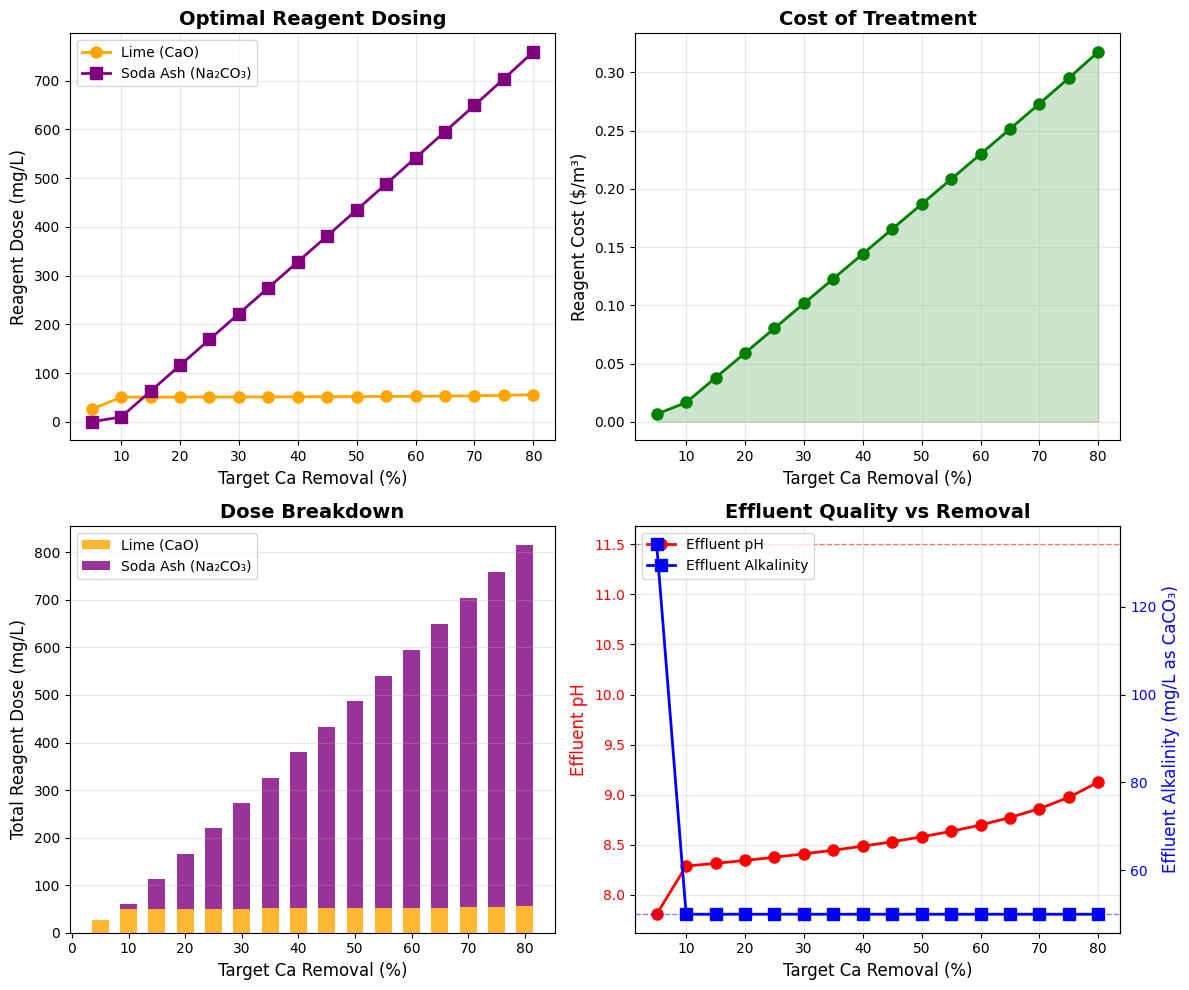

In [12]:
# Create figure with 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Reagent doses vs target removal
ax1 = axes[0, 0]
ax1.plot(targets, lime_doses, 'o-', color='orange', linewidth=2, markersize=8, label='Lime (CaO)')
ax1.plot(targets, soda_doses, 's-', color='purple', linewidth=2, markersize=8, label='Soda Ash (Na₂CO₃)')
ax1.set_xlabel('Target Ca Removal (%)', fontsize=12)
ax1.set_ylabel('Reagent Dose (mg/L)', fontsize=12)
ax1.set_title('Optimal Reagent Dosing', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Cost vs target removal
ax2 = axes[0, 1]
ax2.plot(targets, costs, 'o-', color='green', linewidth=2, markersize=8)
ax2.fill_between(targets, costs, alpha=0.2, color='green')
ax2.set_xlabel('Target Ca Removal (%)', fontsize=12)
ax2.set_ylabel('Reagent Cost ($/m³)', fontsize=12)
ax2.set_title('Cost of Treatment', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Stacked dose breakdown
ax3 = axes[1, 0]
ax3.bar(targets, lime_doses, width=3, label='Lime (CaO)', color='orange', alpha=0.8)
ax3.bar(targets, soda_doses, width=3, bottom=lime_doses, label='Soda Ash (Na₂CO₃)', color='purple', alpha=0.8)
ax3.set_xlabel('Target Ca Removal (%)', fontsize=12)
ax3.set_ylabel('Total Reagent Dose (mg/L)', fontsize=12)
ax3.set_title('Dose Breakdown', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Effluent pH and Alkalinity vs Ca Removal
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()  # Secondary y-axis for alkalinity

# pH on left axis
line1, = ax4.plot(targets, pHs, 'o-', color='red', linewidth=2, markersize=8, label='Effluent pH')
ax4.set_xlabel('Target Ca Removal (%)', fontsize=12)
ax4.set_ylabel('Effluent pH', fontsize=12, color='red')
ax4.tick_params(axis='y', labelcolor='red')
ax4.axhline(y=11.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='pH Limit (11.5)')

# Alkalinity on right axis
line2, = ax4_twin.plot(targets, alkalinities, 's-', color='blue', linewidth=2, markersize=8, label='Effluent Alkalinity')
ax4_twin.set_ylabel('Effluent Alkalinity (mg/L as CaCO₃)', fontsize=12, color='blue')
ax4_twin.tick_params(axis='y', labelcolor='blue')
ax4_twin.axhline(y=50, color='blue', linestyle='--', linewidth=1, alpha=0.5, label='Alk Min (50)')

# Combined legend
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax4.legend(lines, labels, loc='upper left', fontsize=10)

ax4.set_title('Effluent Quality vs Removal', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()

Test evaluation:
  Ca removal: 23.5%
  Effluent pH: 10.74
  Alkalinity: 33.6 mg/L as CaCO3
  Cost: $0.1050/m³
Running parametric sweep: 25x25 = 625 evaluations
Lime range: 0 - 500 mg/L
Soda range: 0 - 1000 mg/L
  Progress: 20%
  Progress: 40%
  Progress: 60%
  Progress: 80%
  Progress: 100%

Sweep complete. Failed evaluations: 0/625


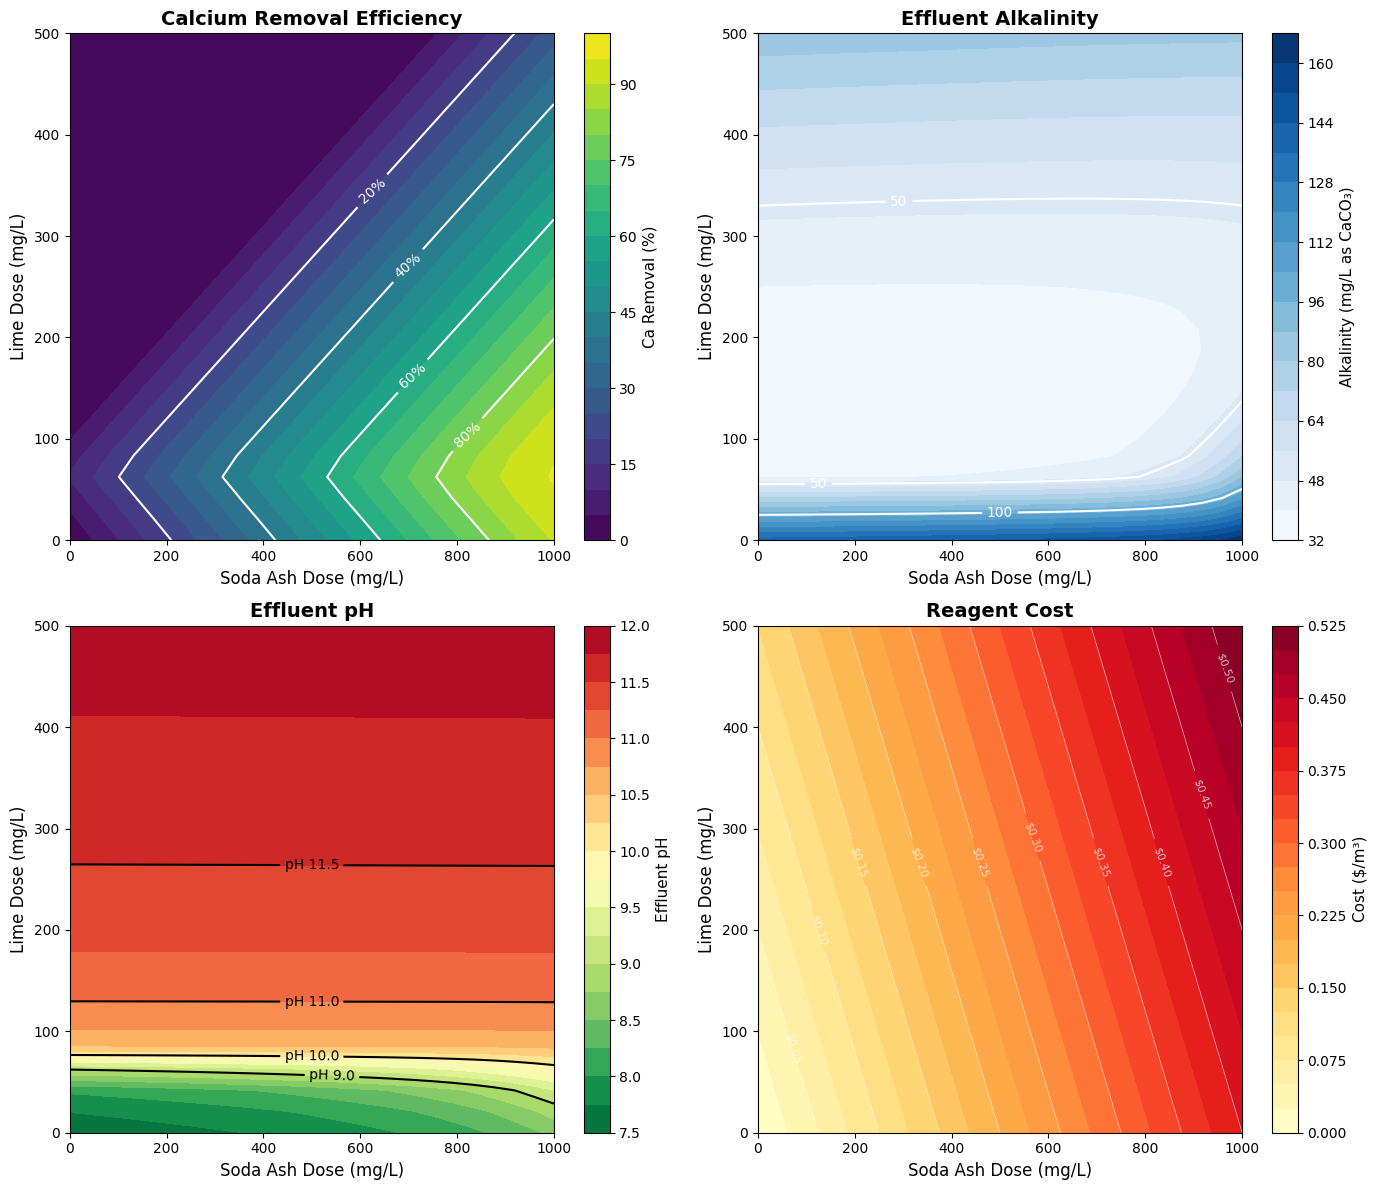


✓ Figure saved to 'reaktoro_parametric_sweep.png'


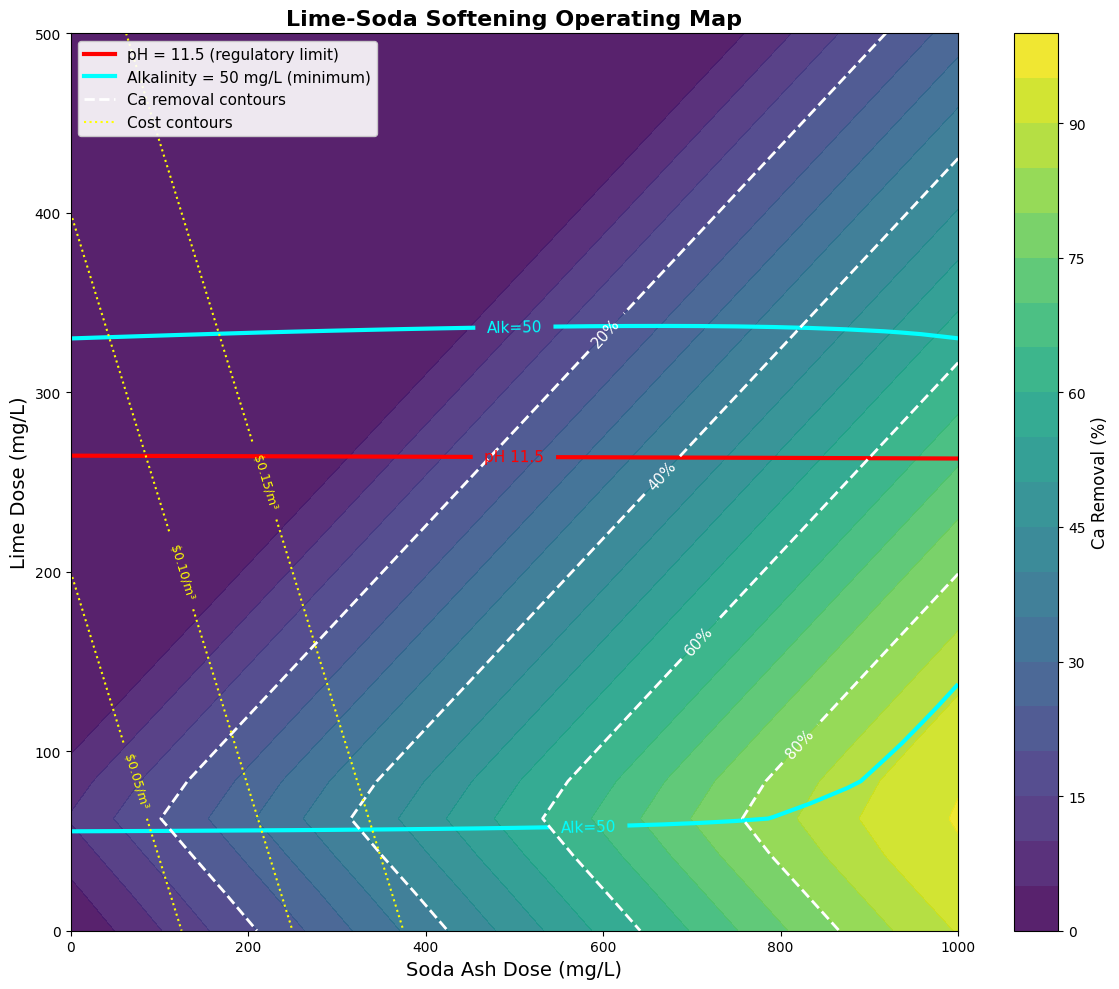


✓ Figure saved to 'operating_map.png'


In [13]:
# %% [markdown]
# ## Parametric Sweep Using Reaktoro Directly
# 
# Instead of solving the full WaterTAP model, we evaluate Reaktoro directly
# at each lime/soda combination. This is faster and avoids convergence issues.

# %%
import numpy as np
import matplotlib.pyplot as plt
import reaktoro

# %%
# Define feed composition (same as WaterTAP model)
feed_composition = {
    "Na": 10556e-3,   # mg/L -> g/L
    "K": 380e-3,
    "Ca": 400e-3,
    "Mg": 1272e-3,
    "Cl": 18980e-3,
    "SO4": 2649e-3,
    "HCO3": 140e-3,
}

feed_pH = 7.9
temperature_C = 20
pressure_Pa = 101325

# Chemical costs ($/kg)
lime_cost = lime_cost
soda_cost = soda_cost

# %%
# Set up Reaktoro system
db = reaktoro.PhreeqcDatabase("pitzer.dat")

solution = reaktoro.AqueousPhase(reaktoro.speciate("H O Na K Ca Mg Cl S C"))
solution.set(reaktoro.ActivityModelPitzer())

mineral = reaktoro.MineralPhase("Calcite")

system = reaktoro.ChemicalSystem(db, solution, mineral)

# %%
def evaluate_softening(lime_dose_mg_L, soda_dose_mg_L, feed_comp, feed_pH, temp_C):
    """
    Evaluate lime-soda softening using Reaktoro.
    
    Args:
        lime_dose_mg_L: Lime (CaO) dose in mg/L
        soda_dose_mg_L: Soda ash (Na2CO3) dose in mg/L
        feed_comp: Dict of feed concentrations in g/L
        feed_pH: Feed pH
        temp_C: Temperature in Celsius
    
    Returns:
        Dict with Ca removal %, effluent pH, alkalinity, cost
    """
    
    # Create chemical state
    state = reaktoro.ChemicalState(system)
    state.temperature(temp_C, "celsius")
    state.pressure(pressure_Pa, "Pa")
    
    # Add 1 kg of water as basis
    state.set("H2O", 1.0, "kg")
    
    # Add feed components (convert g/L to mol, assuming 1 L = 1 kg water)
    state.set("Na+", feed_comp["Na"] / 22.99, "mol")
    state.set("K+", feed_comp["K"] / 39.10, "mol")
    state.set("Ca+2", feed_comp["Ca"] / 40.08, "mol")
    state.set("Mg+2", feed_comp["Mg"] / 24.31, "mol")
    state.set("Cl-", feed_comp["Cl"] / 35.45, "mol")
    state.set("SO4-2", feed_comp["SO4"] / 96.06, "mol")
    state.set("HCO3-", feed_comp["HCO3"] / 61.02, "mol")
    
    # Add lime: CaO + H2O -> Ca(OH)2 -> Ca2+ + 2OH-
    # Lime adds Ca and raises pH
    lime_mol = lime_dose_mg_L * 1e-3 / 56.08  # mg/L -> g/L -> mol/L
    if lime_mol > 0:
        state.add("Ca+2", lime_mol, "mol")
        state.add("OH-", 2 * lime_mol, "mol")
    
    # Add soda ash: Na2CO3 -> 2Na+ + CO32-
    soda_mol = soda_dose_mg_L * 1e-3 / 105.99  # mg/L -> g/L -> mol/L
    if soda_mol > 0:
        state.add("Na+", 2 * soda_mol, "mol")
        state.add("CO3-2", soda_mol, "mol")
    
    # Calculate initial Ca (feed + lime addition)
    feed_ca_mol = feed_comp["Ca"] / 40.08
    total_ca_in = feed_ca_mol + lime_mol
    
    # Equilibrate
    solver = reaktoro.EquilibriumSolver(system)
    
    try:
        result = solver.solve(state)
        
        if not result.succeeded():
            return None
        
        # Get results
        props = reaktoro.ChemicalProps(state)
        aqueous_props = reaktoro.AqueousProps(props)
        
        # Effluent Ca (mol)
        effluent_ca_mol = float(state.speciesAmount("Ca+2"))
        
        # Ca removal based on feed Ca only 
        ca_removal = 100 * (feed_ca_mol - effluent_ca_mol) / feed_ca_mol
        ca_removal = max(0, min(100, ca_removal))  # Prevent negative values and values over 100%
        
        # Effluent pH
        effluent_pH = float(aqueous_props.pH())
        
        # Alkalinity (as mg/L CaCO3)
        alkalinity = float(aqueous_props.alkalinity()) * 50.04 * 1000  # eq/L -> mg/L as CaCO3
        
        # Calcite precipitated (mol)
        calcite_mol = float(state.speciesAmount("Calcite"))
        
        # Cost ($/m3)
        cost = (lime_dose_mg_L * 1e-6 * lime_cost + 
                soda_dose_mg_L * 1e-6 * soda_cost) * 1000  # $/L -> $/m3
        
        return {
            "ca_removal": ca_removal,
            "effluent_pH": effluent_pH,
            "alkalinity": alkalinity,
            "calcite_mol": calcite_mol,
            "cost": cost,
            "effluent_ca_mol": effluent_ca_mol,
        }
        
    except Exception as e:
        print(f"Error at lime={lime_dose_mg_L:.1f}, soda={soda_dose_mg_L:.1f}: {e}")
        return None

# %%
# Test single point
test_result = evaluate_softening(100, 200, feed_composition, feed_pH, temperature_C)
if test_result:
    print("Test evaluation:")
    print(f"  Ca removal: {test_result['ca_removal']:.1f}%")
    print(f"  Effluent pH: {test_result['effluent_pH']:.2f}")
    print(f"  Alkalinity: {test_result['alkalinity']:.1f} mg/L as CaCO3")
    print(f"  Cost: ${test_result['cost']:.4f}/m³")

# %%
# Define sweep ranges (mg/L)
n_points = 25  # Higher resolution since Reaktoro is fast

lime_range = np.linspace(0, 500, n_points)    # mg/L
soda_range = np.linspace(0, 1000, n_points)   # mg/L

# Storage arrays
ca_removal_grid = np.zeros((n_points, n_points))
alkalinity_grid = np.zeros((n_points, n_points))
pH_grid = np.zeros((n_points, n_points))
cost_grid = np.zeros((n_points, n_points))

print(f"Running parametric sweep: {n_points}x{n_points} = {n_points**2} evaluations")
print(f"Lime range: {lime_range[0]:.0f} - {lime_range[-1]:.0f} mg/L")
print(f"Soda range: {soda_range[0]:.0f} - {soda_range[-1]:.0f} mg/L")

# %%
# Run the sweep
failed_count = 0

for i, lime_dose in enumerate(lime_range):
    for j, soda_dose in enumerate(soda_range):
        result = evaluate_softening(lime_dose, soda_dose, feed_composition, feed_pH, temperature_C)
        
        if result is not None:
            ca_removal_grid[i, j] = result["ca_removal"]
            alkalinity_grid[i, j] = result["alkalinity"]
            pH_grid[i, j] = result["effluent_pH"]
            cost_grid[i, j] = result["cost"]
        else:
            ca_removal_grid[i, j] = np.nan
            alkalinity_grid[i, j] = np.nan
            pH_grid[i, j] = np.nan
            cost_grid[i, j] = np.nan
            failed_count += 1
    
    # Progress update
    if (i + 1) % 5 == 0:
        print(f"  Progress: {100 * (i + 1) / n_points:.0f}%")

print(f"\nSweep complete. Failed evaluations: {failed_count}/{n_points**2}")

# %%
# Create meshgrid for plotting
SODA, LIME = np.meshgrid(soda_range, lime_range)

# %%
# Create 2x2 contour plot figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Common settings
contour_levels = 20

# Plot 1: Ca Removal Efficiency
ax1 = axes[0, 0]
cf1 = ax1.contourf(SODA, LIME, ca_removal_grid, levels=contour_levels, cmap='viridis')
cs1 = ax1.contour(SODA, LIME, ca_removal_grid, levels=[20, 40, 60, 80], colors='white', linewidths=1.5)
ax1.clabel(cs1, inline=True, fontsize=10, fmt='%.0f%%')
cbar1 = plt.colorbar(cf1, ax=ax1)
cbar1.set_label('Ca Removal (%)', fontsize=11)
ax1.set_xlabel('Soda Ash Dose (mg/L)', fontsize=12)
ax1.set_ylabel('Lime Dose (mg/L)', fontsize=12)
ax1.set_title('Calcium Removal Efficiency', fontsize=14, fontweight='bold')

# Plot 2: Effluent Alkalinity
ax2 = axes[0, 1]
cf2 = ax2.contourf(SODA, LIME, alkalinity_grid, levels=contour_levels, cmap='Blues')
cs2 = ax2.contour(SODA, LIME, alkalinity_grid, levels=[50, 100, 200, 500], colors='white', linewidths=1.5)
ax2.clabel(cs2, inline=True, fontsize=10, fmt='%.0f')
cbar2 = plt.colorbar(cf2, ax=ax2)
cbar2.set_label('Alkalinity (mg/L as CaCO₃)', fontsize=11)
ax2.set_xlabel('Soda Ash Dose (mg/L)', fontsize=12)
ax2.set_ylabel('Lime Dose (mg/L)', fontsize=12)
ax2.set_title('Effluent Alkalinity', fontsize=14, fontweight='bold')

# Plot 3: Effluent pH
ax3 = axes[1, 0]
cf3 = ax3.contourf(SODA, LIME, pH_grid, levels=contour_levels, cmap='RdYlGn_r')
cs3 = ax3.contour(SODA, LIME, pH_grid, levels=[9, 10, 11, 11.5, 12], colors='black', linewidths=1.5)
ax3.clabel(cs3, inline=True, fontsize=10, fmt='pH %.1f')
cbar3 = plt.colorbar(cf3, ax=ax3)
cbar3.set_label('Effluent pH', fontsize=11)
ax3.set_xlabel('Soda Ash Dose (mg/L)', fontsize=12)
ax3.set_ylabel('Lime Dose (mg/L)', fontsize=12)
ax3.set_title('Effluent pH', fontsize=14, fontweight='bold')

# Plot 4: Reagent Cost
ax4 = axes[1, 1]
cf4 = ax4.contourf(SODA, LIME, cost_grid, levels=contour_levels, cmap='YlOrRd')
cs4 = ax4.contour(SODA, LIME, cost_grid, levels=10, colors='white', linewidths=0.5, alpha=0.7)
ax4.clabel(cs4, inline=True, fontsize=8, fmt='$%.2f')
cbar4 = plt.colorbar(cf4, ax=ax4)
cbar4.set_label('Cost ($/m³)', fontsize=11)
ax4.set_xlabel('Soda Ash Dose (mg/L)', fontsize=12)
ax4.set_ylabel('Lime Dose (mg/L)', fontsize=12)
ax4.set_title('Reagent Cost', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('reaktoro_parametric_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to 'reaktoro_parametric_sweep.png'")

# %%
# Combined Operating Region Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Base: Ca removal as filled contour
cf = ax.contourf(SODA, LIME, ca_removal_grid, levels=20, cmap='viridis', alpha=0.9)
cbar = plt.colorbar(cf, ax=ax)
cbar.set_label('Ca Removal (%)', fontsize=12)

# Overlay: pH limit (e.g., pH = 11.5)
cs_ph = ax.contour(SODA, LIME, pH_grid, levels=[11.5], colors='red', linewidths=3, linestyles='-')
ax.clabel(cs_ph, inline=True, fontsize=11, fmt='pH 11.5')

# Overlay: Minimum alkalinity (e.g., 50 mg/L)
cs_alk = ax.contour(SODA, LIME, alkalinity_grid, levels=[50], colors='cyan', linewidths=3, linestyles='-')
ax.clabel(cs_alk, inline=True, fontsize=11, fmt='Alk=50')

# Overlay: Target removal contours
cs_removal = ax.contour(SODA, LIME, ca_removal_grid, levels=[20, 40, 60, 80], 
                         colors='white', linewidths=2, linestyles='--')
ax.clabel(cs_removal, inline=True, fontsize=11, fmt='%.0f%%')

# Overlay: Cost contours
cs_cost = ax.contour(SODA, LIME, cost_grid, levels=[0.05, 0.10, 0.15], 
                      colors='yellow', linewidths=1.5, linestyles=':')
ax.clabel(cs_cost, inline=True, fontsize=9, fmt='$%.2f/m³')

ax.set_xlabel('Soda Ash Dose (mg/L)', fontsize=14)
ax.set_ylabel('Lime Dose (mg/L)', fontsize=14)
ax.set_title('Lime-Soda Softening Operating Map', fontsize=16, fontweight='bold')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linewidth=3, label='pH = 11.5 (regulatory limit)'),
    Line2D([0], [0], color='cyan', linewidth=3, label='Alkalinity = 50 mg/L (minimum)'),
    Line2D([0], [0], color='white', linewidth=2, linestyle='--', label='Ca removal contours'),
    Line2D([0], [0], color='yellow', linewidth=1.5, linestyle=':', label='Cost contours'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=11, 
          facecolor='white', framealpha=0.9)

plt.tight_layout()
plt.savefig('operating_map.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to 'operating_map.png'")

In [14]:
soda_cost

0.4

In [15]:
# # print results from Reaktoro object
# print("--- Reaktoro Object Results ---")
# for key, obj in m.fs.unit.reaktoro_outputs.items():
#     print(key, value(obj))

# # Print Precipitator Model Results
# print("\n-----------------------")
# print("--- Results Summary ---")
# print("--- Influent ---")
# print(
#     f"Treated Influent Flow - lt/hr: {value(m.fs.unit.aqueous_inlet.flow_vol[0]):.2f}"
# )
# print(f"Treated Influent pH: {value(m.fs.unit.precipitation.feed_pH):.2f}")
# print(
#     f"Treated Influent Temperature - K: {value(m.fs.unit.precipitate_state_block[0].temperature):.2f}"
# )
# print(
#     f"Treated Influent Pressure - Pa: {value(m.fs.unit.precipitation.feed_pressure):.2f}"
# )
# print(
#     f"Treated Influent Ca mass composition: {value(m.fs.unit.aqueous_inlet.conc_mass_comp[0, 'Ca']):.2f}"
# )
# print("\n--- Treated Effluent ---")
# print(
#     f"Treated Effluent Ca flow mass - kg/s: {value(m.fs.unit.cv_aqueous.properties_out[0].flow_mass_comp['Ca']):.2f}"
# )
# print(
#     f"Treated Effluent H2O flow mass - kg/s: {value(m.fs.unit.cv_aqueous.properties_out[0].flow_mass_comp['H2O']):.2f}"
# )
# print(f"Treated Effluent pH: {value(m.fs.unit.precipitation.effluent_pH):.2f}")
# print("-" * 25)
# print("\n--- Precipitation Reagent Dosing ---")
# print(
#     f"Quicklime (CaO) Dose - mg/kg: {value(pyunits.convert*m.fs.unit.precipitation.reagent_dose['CaO']):.3f} [mg/kg]"
# )
# print(
#     f"Soda Ash (Na2CO3) Dose - mg/kg: {value(m.fs.unit.precipitation.reagent_dose['Na2CO3']):.3f} [mg/kg]"
# )
# print("-" * 25)
# print("\n--- Removal Efficiencies ---")
# print(f"Calcium Removal: {value(m.fs.properties_aq.split['Ca']):.2f} %")
# print(
#     f"Bicarbonate/Alkalinity Removal: {value(m.fs.properties_aq.split['HCO3']):.2f} %"
# )
# print("-" * 25)

<img src="precipitation_pfd.png" alt="Chemical Precipitation PFD" width="80%">

### 4.3 Sensitivity Analysis
The sensitivity analysis captures the performance change when adjusting the molar flowrate of the lime and soda ash and its impact in the precipitation performance. Thus we can observe the efficiency of the process to precipitate calcium as a function of the lime and soda ash dose. In addition, we can observe the pH change as a function of lime and soda ash dose, which confirms our initial statement. The results confirm that raising the pH above 7 reduces the solubility of calcite, and adding soda ash facilitate calcite formation. 

In [16]:
# Pick a point from your optimization results
target_lime = results_list[5]["lime_dose"]  # mg/L
target_soda = results_list[5]["soda_dose"]  # mg/L
watertap_cost = results_list[5]["cost"]

# Calculate what Reaktoro would give
reaktoro_cost = (target_lime * 1e-6 * lime_cost + target_soda * 1e-6 * soda_cost) * 1000

print(f"Lime: {target_lime:.1f} mg/L, Soda: {target_soda:.1f} mg/L")
print(f"WaterTAP cost: ${watertap_cost:.6f}")
print(f"Reaktoro cost: ${reaktoro_cost:.6f}")

Lime: 50.9 mg/L, Soda: 222.1 mg/L
WaterTAP cost: $0.101555
Reaktoro cost: $0.101554


In [17]:
results_list[0]["lime_dose"]

np.float64(25.89736447945252)

In [18]:
.101555/.014950

6.792976588628763

In [19]:
# Compare at same doses
lime_dose = 50.9  # mg/L
soda_dose = 222.1  # mg/L

# WaterTAP result
watertap_removal = results_list[5]["achieved"]  # %

# Reaktoro result
rkt_result = evaluate_softening(lime_dose, soda_dose, feed_composition, feed_pH, temperature_C)
reaktoro_removal = rkt_result["ca_removal"]  # %

print(f"WaterTAP Ca removal: {watertap_removal:.1f}%")
print(f"Reaktoro Ca removal: {reaktoro_removal:.1f}%")

WaterTAP Ca removal: 30.0%
Reaktoro Ca removal: 29.5%


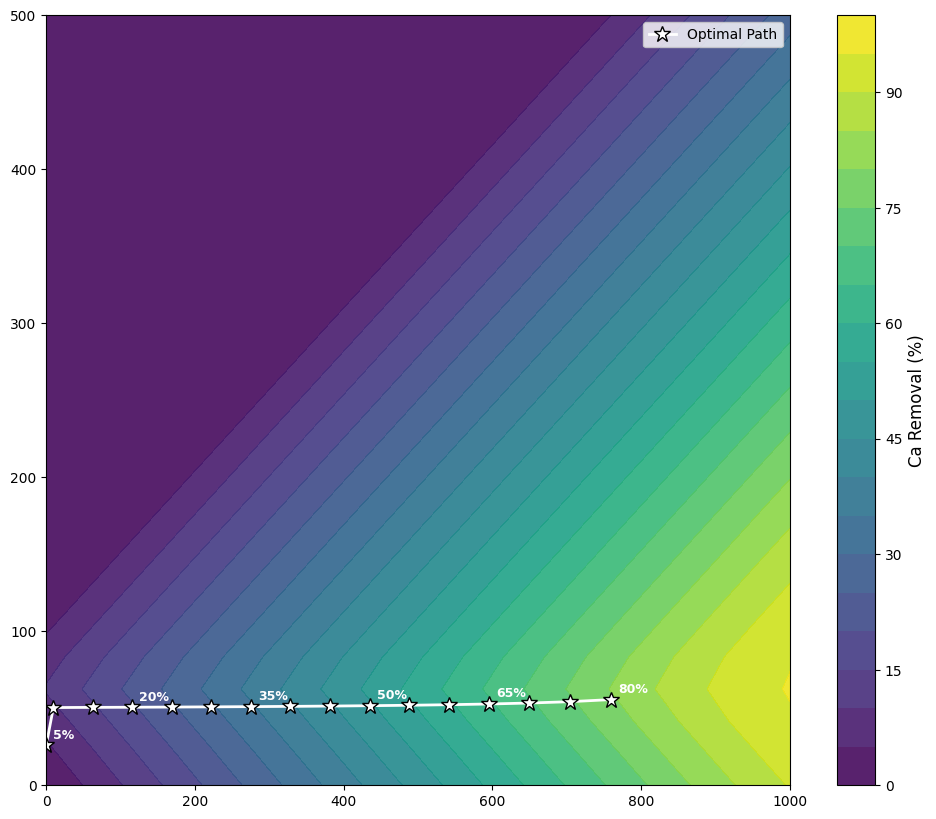

In [20]:
# On your operating map, add the optimization path
fig, ax = plt.subplots(figsize=(12, 10))

# Base contour (Ca removal)
cf = ax.contourf(SODA, LIME, ca_removal_grid, levels=20, cmap='viridis', alpha=0.9)
cbar = plt.colorbar(cf, ax=ax)
cbar.set_label('Ca Removal (%)', fontsize=12)

# ... other contours ...

# Overlay optimization path
ax.plot(soda_doses, lime_doses, 'w*-', markersize=12, linewidth=2, 
        markeredgecolor='black', label='Optimal Path')

# Label a few points with target removal
for i in range(0, len(targets), 3):  # Every 3rd point
    ax.annotate(f'{targets[i]}%', (soda_doses[i], lime_doses[i]), 
                fontsize=9, color='white', fontweight='bold',
                xytext=(5, 5), textcoords='offset points')

ax.legend()

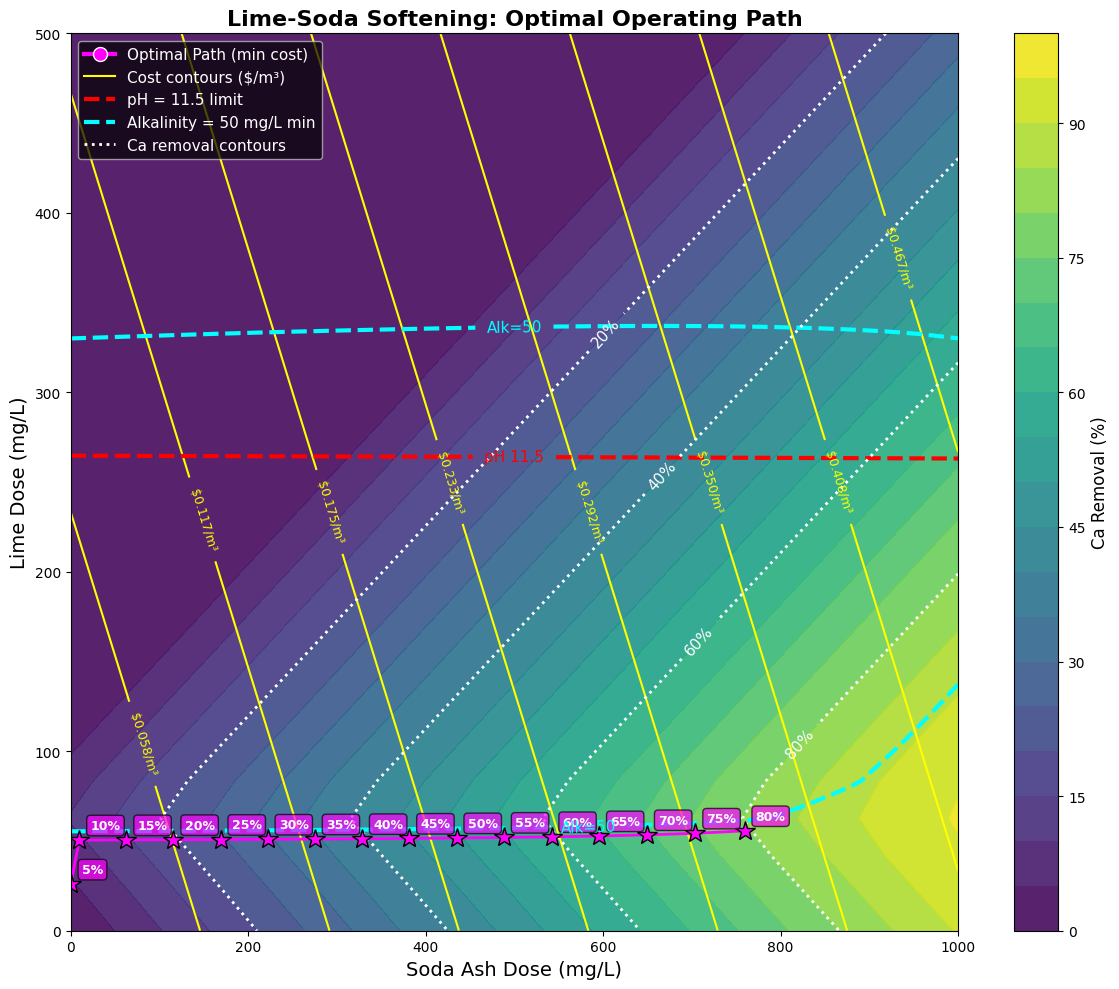


✓ Figure saved to 'optimal_path_with_costs.png'


In [21]:
# Combined Operating Region Plot with Optimization Path
fig, ax = plt.subplots(figsize=(12, 10))

# Base: Ca removal as filled contour
cf = ax.contourf(SODA, LIME, ca_removal_grid, levels=20, cmap='viridis', alpha=0.9)
cbar = plt.colorbar(cf, ax=ax)
cbar.set_label('Ca Removal (%)', fontsize=12)

# Overlay: Cost contours
cost_levels = np.linspace(cost_grid[~np.isnan(cost_grid)].min(), 
                          cost_grid[~np.isnan(cost_grid)].max(), 10)
cs_cost = ax.contour(SODA, LIME, cost_grid, levels=cost_levels, 
                      colors='yellow', linewidths=1.5, linestyles='-')
ax.clabel(cs_cost, inline=True, fontsize=9, fmt='$%.3f/m³')

# Overlay: pH limit (e.g., pH = 11.5)
cs_ph = ax.contour(SODA, LIME, pH_grid, levels=[11.5], 
                    colors='red', linewidths=3, linestyles='--')
ax.clabel(cs_ph, inline=True, fontsize=11, fmt='pH 11.5')

# Overlay: Minimum alkalinity (e.g., 50 mg/L)
cs_alk = ax.contour(SODA, LIME, alkalinity_grid, levels=[50], 
                     colors='cyan', linewidths=3, linestyles='--')
ax.clabel(cs_alk, inline=True, fontsize=11, fmt='Alk=50')

# Overlay: Target removal contours
cs_removal = ax.contour(SODA, LIME, ca_removal_grid, levels=[20, 40, 60, 80], 
                         colors='white', linewidths=2, linestyles=':')
ax.clabel(cs_removal, inline=True, fontsize=11, fmt='%.0f%%')

# Overlay: Optimization path from WaterTAP results
# ax.plot(soda_doses, lime_doses, 'o-', color='magenta', markersize=10, 
#         linewidth=3, markeredgecolor='white', markeredgewidth=2,
#         label='Optimal Path (min cost)')
ax.plot(soda_doses, lime_doses, '*-', color='magenta', markersize=15, 
        linewidth=2, markeredgecolor='black', markeredgewidth=1,
        label='Optimal Path (min cost)')

# Label points with target removal
for i, target in enumerate(targets):
    ax.annotate(f'{target}%', 
                (soda_doses[i], lime_doses[i]),
                fontsize=9, color='white', fontweight='bold',
                xytext=(8, 8), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='magenta', alpha=0.7))

ax.set_xlabel('Soda Ash Dose (mg/L)', fontsize=14)
ax.set_ylabel('Lime Dose (mg/L)', fontsize=14)
ax.set_title('Lime-Soda Softening: Optimal Operating Path', fontsize=16, fontweight='bold')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='magenta', linewidth=3, marker='o', markersize=10,
           markeredgecolor='white', label='Optimal Path (min cost)'),
    Line2D([0], [0], color='yellow', linewidth=1.5, label='Cost contours ($/m³)'),
    Line2D([0], [0], color='red', linewidth=3, linestyle='--', label='pH = 11.5 limit'),
    Line2D([0], [0], color='cyan', linewidth=3, linestyle='--', label='Alkalinity = 50 mg/L min'),
    Line2D([0], [0], color='white', linewidth=2, linestyle=':', label='Ca removal contours'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=11, 
          facecolor='black', framealpha=0.7, labelcolor='white')

plt.tight_layout()
plt.savefig('optimal_path_with_costs.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved to 'optimal_path_with_costs.png'")